# Import library 

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
!pip install transformers
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.8 MB/s eta 0:00:00


# Load dataset

In [ ]:
train_path = 'propaganda_train.tsv'
val_path = 'propaganda_val.tsv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.model_selection import train_test_split
def load_dataset(file_path):
    data = pd.read_csv(file_path, sep='\t', header=None, skiprows=1,names=['label', 'sentence'])
    data['propaganda'] = data['label'].apply(lambda x: 0 if x == 'not_propaganda' else 1)
    
    sentences = data['sentence'].tolist()
    labels = data['propaganda'].tolist()

    return sentences, labels

X_train,y_train = load_dataset(train_path)
# Splitting the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
                                                  
X_test,y_test = load_dataset(val_path)


# Analysis of the dataset

In [ ]:
print(X_train[0:10])
print(len(X_train))

['Thus, we clearly gauge that there is no disgusting and venomous level to which the Left will not stoop in its <BOS> destructive agenda <EOS>. ', 'In 2015, Carmelite monasteries received a questionnaire <BOS> from the <EOS> Father General Fr. ', "<BOS> When Arnold complained, the professor said they'd reexamine the assignment, but <EOS> did not concede that Australia was a country. ", 'A report made public this week by Spencer Boudreau concluded <BOS> he could not determine if students who organized against <EOS> the three board members had anti-Semitic intentions. ', 'Archbishop Viganò now provides his own decisive summary of the situation, based on firsthand experience with a now <BOS> endemic homosexual corruption <EOS> of the Church: ', '<BOS> After all, it is not the injury to relatives or any other human consideration that makes homicide the serious sin that it is, but as God Himself pointed out to Noah, it is the fact that “man was made to the image of God” that makes an assaul

In [ ]:
print(y_train[0:10])
print(len(y_train))

[1, 0, 0, 0, 1, 1, 0, 1, 1, 0]
2172


In [ ]:
propaganda_count = 0
not_propaganda_count = 0
for label in y_train:
  if label == 1:
    propaganda_count += 1
  else:
    not_propaganda_count += 1

print(f"There are {propaganda_count} propaganda and {not_propaganda_count} non propaganda ")

There are 1095 propaganda and 1077 non propaganda 


In [ ]:
unique_words = set()
for sentence in X_train:
    for word in sentence.split():
        unique_words.add(word.lower())
print(f"Number of unique words in X_train: {len(unique_words)}")

Number of unique words in X_train: 11936


Token indices sequence length is longer than the specified maximum sequence length for this model (1942 > 512). Running this sequence through the model will result in indexing errors


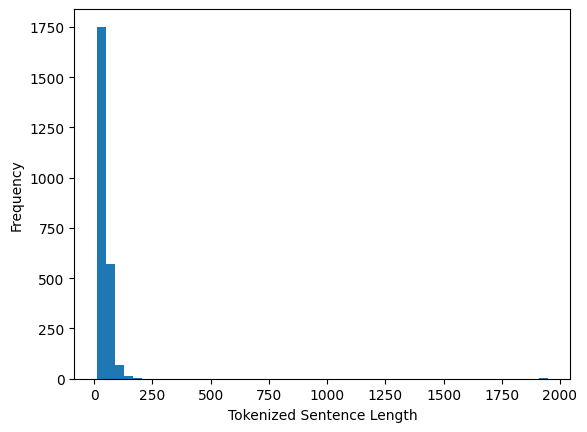

Mean length: 45.15907207953604
Median length: 38
90th percentile length: 70
95th percentile length: 84
99th percentile length: 120


In [ ]:
import matplotlib.pyplot as plt

def analyze_sentence_lengths(sentences, tokenizer):
    tokenized_lengths = [len(tokenizer.encode(sentence)) for sentence in sentences]
    plt.hist(tokenized_lengths, bins=50)
    plt.xlabel('Tokenized Sentence Length')
    plt.ylabel('Frequency')
    plt.show()

    mean_length = sum(tokenized_lengths) / len(tokenized_lengths)
    median_length = sorted(tokenized_lengths)[len(tokenized_lengths) // 2]
    percentile_90 = sorted(tokenized_lengths)[int(0.9 * len(tokenized_lengths))]
    percentile_95 = sorted(tokenized_lengths)[int(0.95 * len(tokenized_lengths))]
    percentile_99 = sorted(tokenized_lengths)[int(0.99 * len(tokenized_lengths))]

    print(f'Mean length: {mean_length}')
    print(f'Median length: {median_length}')
    print(f'90th percentile length: {percentile_90}')
    print(f'95th percentile length: {percentile_95}')
    print(f'99th percentile length: {percentile_99}')


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
analyze_sentence_lengths(X_train, tokenizer)

# Pre-trained Bert model approach

In [ ]:
class PropagandaDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_length):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 120
batch_size = 32

train_dataset = PropagandaDataset(X_train, y_train, tokenizer, max_length)
val_dataset = PropagandaDataset(X_val, y_val, tokenizer, max_length)
test_dataset = PropagandaDataset(X_test, y_test, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

## Baseline

In [ ]:
from torch import nn
from transformers import BertModel, AutoConfig

class BertClassifier(nn.Module):
    
    def __init__(self, pretrained_model='bert-base-uncased', dropout=0.5, num_classes=2):
        
        super(BertClassifier, self).__init__()
        
        config = AutoConfig.from_pretrained(pretrained_model)
        self.bert = BertModel.from_pretrained(pretrained_model, config=config)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(config.hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, input_id, mask):
        
        last_hidden_layer, pooled_output = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.softmax(linear_output)
        
        return final_layer







In [ ]:
model = BertClassifier(pretrained_model='bert-base-uncased', dropout=0.1, num_classes=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
loss_fn = torch.nn.CrossEntropyLoss()

patience = 3
early_stopping_counter = 0
best_val_f1 = -float('inf')

for epoch in range(30):
    model.train()
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validate the model
    model.eval()
    val_predictions = []
    val_labels = []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            predictions = torch.argmax(outputs, dim=1)

            val_predictions.extend(predictions.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    precision, recall, val_f1, _ = precision_recall_fscore_support(val_labels, val_predictions, average='weighted')
    print(f"Epoch: {epoch+1}, Validation F1: {val_f1}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered.")
        break

# Evaluate the model on the test set
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        predictions = torch.argmax(outputs, dim=1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_predictions)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1_score}")

Epoch: 1, Validation F1: 0.9091282562011765
Epoch: 2, Validation F1: 0.9174119158445178
Epoch: 3, Validation F1: 0.9174119158445178
Epoch: 4, Validation F1: 0.9215480150126271
Epoch: 5, Validation F1: 0.9215050818768447
Epoch: 6, Validation F1: 0.92980606698734
Epoch: 7, Validation F1: 0.9215533489682309
Epoch: 8, Validation F1: 0.9173892426500475
Epoch: 9, Validation F1: 0.9339295326756142
Epoch: 10, Validation F1: 0.9256808645899555
Epoch: 11, Validation F1: 0.9297340041158695
Epoch: 12, Validation F1: 0.9215319355455899
Early stopping triggered.
Accuracy: 0.9310344827586207
Precision: 0.931152637622724
Recall: 0.9310344827586207
F1-score: 0.9310492577417833


## Hyper-parameter tuning

In [ ]:
from sklearn.metrics import f1_score

from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

def grid_search(X_train, y_train, X_val, y_val, tokenizer, max_length):
    best_result = None
    best_f1 = float('-inf')

    learning_rates = [1e-5,1e-6,1e-7]
    batch_sizes = [32, 64]
    patience = 3
    dropouts = [0.1, 0.2, 0.3]
    weight_decays = [0.01, 0.001, 0.0001]

    total_combinations = len(learning_rates) * len(batch_sizes) * len(dropouts) * len(weight_decays)
    current_combination = 0

    for lr in learning_rates:
        for bs in batch_sizes:
            for do in dropouts:
                for wd in weight_decays:
                    current_combination += 1
                    # Create a model with the current hyperparameters
                    model = BertClassifier(dropout=do).to(device)

                    # Create dataloaders
                    train_dataset = PropagandaDataset(X_train, y_train, tokenizer, max_length)
                    train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
                    val_dataset = PropagandaDataset(X_val, y_val, tokenizer, max_length)
                    val_dataloader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

                    # Train the model
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
                    loss_fn = torch.nn.CrossEntropyLoss()
                    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold=1e-3, verbose=False)

                    early_stopping_counter = 0
                    best_val_f1 = -float('inf')

                    for epoch in range(10):
                        model.train()
                        for batch in train_dataloader:
                            input_ids = batch['input_ids'].to(device)
                            attention_mask = batch['attention_mask'].to(device)
                            labels = batch['label'].to(device)

                            optimizer.zero_grad()
                            outputs = model(input_ids, attention_mask)
                            loss = loss_fn(outputs, labels)
                            loss.backward()
                            optimizer.step()

                        # Evaluate the model
                        model.eval()
                        val_predictions = []
                        val_labels = []

                        with torch.no_grad():
                            for batch in val_dataloader:
                                input_ids = batch['input_ids'].to(device)
                                attention_mask = batch['attention_mask'].to(device)
                                labels = batch['label'].to(device)

                                outputs = model(input_ids, attention_mask)
                                predictions = torch.argmax(outputs, dim=1)

                                val_predictions.extend(predictions.cpu().numpy())
                                val_labels.extend(labels.cpu().numpy())

                        val_f1 = f1_score(val_labels, val_predictions, average='weighted')

                        if val_f1 > best_val_f1:
                            best_val_f1 = val_f1
                            early_stopping_counter = 0
                        else:
                            early_stopping_counter += 1

                        if val_f1 > best_f1:
                            best_f1 = val_f1
                            best_result = {
                                'learning_rate': lr,
                                'batch_size': bs,
                                'dropout': do,
                                'weight_decay': wd,
                                'f1_score': best_f1
                            }

                        if early_stopping_counter >= patience:
                            progress = current_combination / total_combinations
                            print(f"Progress: {progress:.2%} | {current_combination}/{total_combinations} | Current Best Result: {best_result}")
                            break

                        scheduler.step(val_f1)

    return best_result

result = grid_search(X_train, y_train, X_val, y_val, tokenizer, max_length)



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predicti

Progress: 3.70% | 2/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.1, 'weight_decay': 0.01, 'f1_score': 0.942172526673476}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progress: 5.56% | 3/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.1, 'weight_decay': 0.01, 'f1_score': 0.942172526673476}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progress: 7.41% | 4/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.2, 'weight_decay': 0.01, 'f1_score': 0.9504471495067106}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predicti

Progress: 12.96% | 7/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.2, 'weight_decay': 0.01, 'f1_score': 0.9504471495067106}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progress: 14.81% | 8/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.2, 'weight_decay': 0.01, 'f1_score': 0.9504471495067106}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progress: 16.67% | 9/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 32, 'dropout': 0.2, 'weight_decay': 0.01, 'f1_score': 0.9504471495067106}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predicti

Progress: 27.78% | 15/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 64, 'dropout': 0.2, 'weight_decay': 0.01, 'f1_score': 0.9545711205790258}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predicti

Progress: 40.74% | 22/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 64, 'dropout': 0.3, 'weight_decay': 0.001, 'f1_score': 0.9545804297441526}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predicti

Progress: 51.85% | 28/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 64, 'dropout': 0.3, 'weight_decay': 0.001, 'f1_score': 0.9545804297441526}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predicti

Progress: 68.52% | 37/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 64, 'dropout': 0.3, 'weight_decay': 0.001, 'f1_score': 0.9545804297441526}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progress: 70.37% | 38/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 64, 'dropout': 0.3, 'weight_decay': 0.001, 'f1_score': 0.9545804297441526}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predicti

Progress: 77.78% | 42/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 64, 'dropout': 0.3, 'weight_decay': 0.001, 'f1_score': 0.9545804297441526}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progress: 79.63% | 43/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 64, 'dropout': 0.3, 'weight_decay': 0.001, 'f1_score': 0.9545804297441526}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predicti

Progress: 85.19% | 46/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 64, 'dropout': 0.3, 'weight_decay': 0.001, 'f1_score': 0.9545804297441526}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progress: 87.04% | 47/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 64, 'dropout': 0.3, 'weight_decay': 0.001, 'f1_score': 0.9545804297441526}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predicti

Progress: 90.74% | 49/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 64, 'dropout': 0.3, 'weight_decay': 0.001, 'f1_score': 0.9545804297441526}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progress: 92.59% | 50/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 64, 'dropout': 0.3, 'weight_decay': 0.001, 'f1_score': 0.9545804297441526}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predicti

Progress: 96.30% | 52/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 64, 'dropout': 0.3, 'weight_decay': 0.001, 'f1_score': 0.9545804297441526}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progress: 98.15% | 53/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 64, 'dropout': 0.3, 'weight_decay': 0.001, 'f1_score': 0.9545804297441526}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Progress: 100.00% | 54/54 | Current Best Result: {'learning_rate': 1e-05, 'batch_size': 64, 'dropout': 0.3, 'weight_decay': 0.001, 'f1_score': 0.9545804297441526}


In [ ]:
print(result)

{'learning_rate': 1e-05, 'batch_size': 64, 'dropout': 0.3, 'weight_decay': 0.001, 'f1_score': 0.9545804297441526}


## Evaluate


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from torch.optim.lr_scheduler import ReduceLROnPlateau


def train_best_model(X_train, y_train, X_val, y_val, tokenizer, max_length, best_params):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Unpack best parameters
    best_lr = best_params['learning_rate']
    best_bs = best_params['batch_size']
    best_dropout = best_params['dropout']
    best_wd = best_params['weight_decay']

    # Create model with best dropout
    model = BertClassifier(dropout=best_dropout).to(device)

    # Create dataloaders
    train_dataset = PropagandaDataset(X_train, y_train, tokenizer, max_length)
    train_dataloader = DataLoader(train_dataset, batch_size=best_bs, shuffle=True)
    val_dataset = PropagandaDataset(X_val, y_val, tokenizer, max_length)
    val_dataloader = DataLoader(val_dataset, batch_size=best_bs, shuffle=False)

    # Create optimizer with best learning rate and weight decay
    optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=best_wd)
    loss_fn = torch.nn.CrossEntropyLoss()

    early_stopping_counter = 0
    best_val_f1 = -float('inf')

    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold=1e-3, verbose=False)

    # Train the model with early stopping
    for epoch in range(10):
        model.train()
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate the model on validation set
        model.eval()
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids, attention_mask)
                predictions = torch.argmax(outputs, dim=1)

                val_predictions.extend(predictions.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_f1 = f1_score(val_labels, val_predictions, average='weighted')

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= 5:
            break
        
        scheduler.step(val_f1)

    return model

def evaluate_model(model, test_dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_predictions = []
    all_labels = []
    all_input_ids = []

    with torch.no_grad():
      for batch in test_dataloader:
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['label'].to(device)

          outputs = model(input_ids, attention_mask)
          predictions = torch.argmax(outputs, dim=1)

          all_predictions.extend(predictions.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())
          all_input_ids.extend(input_ids.cpu().numpy())


    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
    auc_roc = roc_auc_score(all_labels, all_predictions)

    conf_matrix = confusion_matrix(all_labels, all_predictions)

    cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ["not_propaganda", "propaganda"])

    class_report = classification_report(all_labels,all_predictions,target_names=["not_propaganda", "propaganda"])
  

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1_score:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    
    # Visualize confusion matrix
    cm_display.plot()

    # Visualize classification report
    print(class_report)

    misclassified = [(all_input_ids[i], all_labels[i], all_predictions[i]) for i in range(len(all_labels)) if all_labels[i] != all_predictions[i]]
    correctly_classified = [(all_input_ids[i], all_labels[i], all_predictions[i]) for i in range(len(all_labels)) if all_labels[i] == all_predictions[i]]

    return misclassified,correctly_classified

In [ ]:
result = {'learning_rate': 1e-05, 'batch_size': 64, 'dropout': 0.3, 'weight_decay': 0.001}
# Train the model with the best parameters
best_model = train_best_model(X_train, y_train, X_val, y_val, tokenizer, max_length, result)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Accuracy: 0.9466
Precision: 0.9474
Recall: 0.9466
F1-score: 0.9465
AUC-ROC: 0.9456
                precision    recall  f1-score   support

not_propaganda       0.93      0.97      0.95       301
    propaganda       0.97      0.92      0.94       279

      accuracy                           0.95       580
     macro avg       0.95      0.95      0.95       580
  weighted avg       0.95      0.95      0.95       580



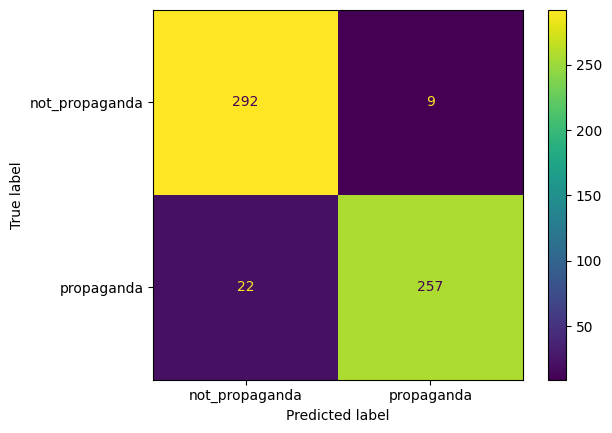

In [ ]:
test_dataset = PropagandaDataset(X_test, y_test, tokenizer, max_length)
test_dataloader = DataLoader(test_dataset, batch_size=result['batch_size'], shuffle=False)
misclassified,correctly_classified = evaluate_model(best_model, test_dataloader)

## Error Analysis


Precision is better for not propaganda whereas recall is better for propaganda. This suggests that the classifier is over-predicting propagada, meaning 

In [ ]:
import pandas as pd

# Decode input_ids back to text
decoded_sentences = [tokenizer.decode(input_id, skip_special_tokens=True) for input_id, _, _ in misclassified]

# Extract actual labels and predicted labels
actual_labels = [actual_label for _, actual_label, _ in misclassified]
predicted_labels = [predicted_label for _, _, predicted_label in misclassified]

# Create a dictionary with column names and data
data = {
    "Misclassified Sentence": decoded_sentences,
    "Actual Label": actual_labels,
    "Predicted Label": predicted_labels,
}

# Create a DataFrame using the data
misclassified_df = pd.DataFrame(data)


In [ ]:
misclassified_df.head()

,Misclassified Sentence,Actual Label,Predicted Label
0,the interview began with the statement bernste...,1,0
1,< bos > they had a right < eos > to find out a...,1,0
2,well aware of the enormous consequences that m...,0,1
3,a < bos > mistake many make < eos > about lyin...,0,1
4,"many nations, notably england, france, sweden,...",1,0


### Sentence length distribution

Test Set - Average Length: 28.91
misclassified - Average Length: 31.65, Maximum Length: 96
Correctly Classified - Average Length: 32.07, Minimum Length: 7


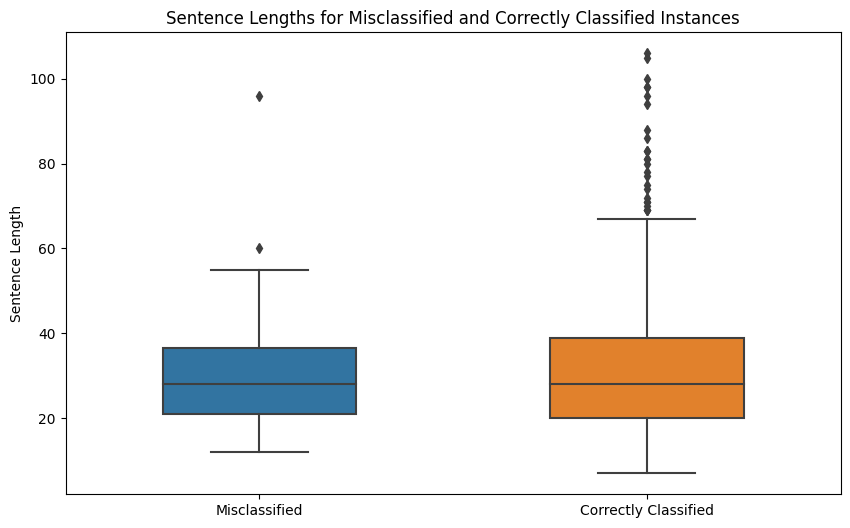

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Decode input_ids back to text for misclassified and correctly classified instances
misclassified_decoded_sentences = [tokenizer.decode(input_id, skip_special_tokens=True) for input_id, _, _ in misclassified]
correctly_classified_decoded_sentences = [tokenizer.decode(input_id, skip_special_tokens=True) for input_id, _, _ in correctly_classified]

# Get lengths of all sentences in the test set
all_lengths = [len(sentence.split()) for sentence in X_test]
misclassified_lengths = [len(decoded_sentence.split()) for decoded_sentence in misclassified_decoded_sentences]
correctly_classified_lengths = [len(decoded_sentence.split()) for decoded_sentence in correctly_classified_decoded_sentences]

# Calculate the statistics
testset_avg_len = sum(all_lengths) / len(all_lengths)
misclassified_avg_len = sum(misclassified_lengths) / len(misclassified_lengths)
misclassified_max_len = max(misclassified_lengths)
correct_avg_len = sum(correctly_classified_lengths) / len(correctly_classified_lengths)
correct_min_len = min(correctly_classified_lengths)

print(f"Test Set - Average Length: {testset_avg_len:.2f}")
print(f"misclassified - Average Length: {misclassified_avg_len:.2f}, Maximum Length: {misclassified_max_len}")
print(f"Correctly Classified - Average Length: {correct_avg_len:.2f}, Minimum Length: {correct_min_len}")

# Visualize the data using box plots
data = [misclassified_lengths, correctly_classified_lengths]
labels = ['Misclassified', 'Correctly Classified']

plt.figure(figsize=(10, 6))
sns.boxplot(data=data, width=0.5)
plt.xticks(range(len(labels)), labels)
plt.ylabel('Sentence Length')
plt.title('Sentence Lengths for Misclassified and Correctly Classified Instances')
plt.show()



### Most frequent word

In [ ]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
from collections import defaultdict
import re
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def get_top_n_words_with_sentence_count(texts, n=10):
    word_freq = defaultdict(int)
    word_sentence_count = defaultdict(int)
    word_pattern = re.compile(r"^[a-z]+$")

    for text in texts:
        text_words = set()
        for word in text.split():
            if word.lower() not in stop_words and word_pattern.match(word.lower()):
                word_freq[word.lower()] += 1
                if word.lower() not in text_words:
                    text_words.add(word.lower())
                    word_sentence_count[word.lower()] += 1

    sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
    sorted_word_sentence_count = [(word, word_sentence_count[word]) for word, freq in sorted_word_freq]

    return list(zip(sorted_word_freq[:n], sorted_word_sentence_count[:n]))


# Get the sentences from misclassified and correctly_classified instances
misclassified_sentences = [tokenizer.convert_ids_to_tokens(input_id) for input_id, _, _ in misclassified]
correctly_classified_sentences = [tokenizer.convert_ids_to_tokens(input_id) for input_id, _, _ in correctly_classified]

# Remove special tokens like '[CLS]', '[SEP]', and '[PAD]'
misclassified_sentences = [" ".join([t for t in tokens if t not in ['[CLS]', '[SEP]', '[PAD]']]) for tokens in misclassified_sentences]
correctly_classified_sentences = [" ".join([t for t in tokens if t not in ['[CLS]', '[SEP]', '[PAD]']]) for tokens in correctly_classified_sentences]

# Get top 10 most frequent words in both categories and their sentence counts
top_10_misclassified_with_sentence_count = get_top_n_words_with_sentence_count(misclassified_sentences)
top_10_correctly_classified_with_sentence_count = get_top_n_words_with_sentence_count(correctly_classified_sentences)

print("Top 10 words in misclassified sentences with their sentence counts:")
for ((word, count), (_, sentence_count)) in top_10_misclassified_with_sentence_count:
    print(f"{word}: {count} (in {sentence_count} sentences)")

print("\nTop 10 words in correctly classified sentences with their sentence counts:")
for ((word, count), (_, sentence_count)) in top_10_correctly_classified_with_sentence_count:
    print(f"{word}: {count} (in {sentence_count} sentences)")

Top 10 words in misclassified sentences with their sentence counts:
bo: 35 (in 31 sentences)
e: 34 (in 31 sentences)
many: 5 (in 4 sentences)
said: 4 (in 4 sentences)
public: 3 (in 3 sentences)
would: 3 (in 3 sentences)
bishops: 3 (in 2 sentences)
values: 3 (in 1 sentences)
propaganda: 3 (in 1 sentences)
world: 3 (in 3 sentences)

Top 10 words in correctly classified sentences with their sentence counts:
e: 562 (in 548 sentences)
bo: 558 (in 549 sentences)
trump: 42 (in 41 sentences)
one: 40 (in 35 sentences)
said: 38 (in 36 sentences)
would: 30 (in 27 sentences)
people: 26 (in 26 sentences)
also: 24 (in 23 sentences)
u: 22 (in 22 sentences)
world: 21 (in 20 sentences)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Grammarticial sturcture analysis

In [ ]:
import spacy
from collections import Counter

nlp = spacy.load('en_core_web_sm')

def get_grammatical_constructs(sentences):
    constructs = []
    for sentence in sentences:
        parsed_sentence = nlp(sentence)
        for token in parsed_sentence:
            constructs.append(token.dep_)
    return Counter(constructs)

misclassified_grammatical_constructs = get_grammatical_constructs(misclassified_decoded_sentences)
correctly_classified_grammatical_constructs = get_grammatical_constructs(correctly_classified_decoded_sentences)

def get_top_n_grammatical_constructs(counter, n=10):
    return counter.most_common(n)

top_10_misclassified_grammatical_constructs = get_top_n_grammatical_constructs(misclassified_grammatical_constructs)
top_10_correctly_classified_grammatical_constructs = get_top_n_grammatical_constructs(correctly_classified_grammatical_constructs)

print("Top 10 grammatical constructs in misclassified sentences:")
for construct, count in top_10_misclassified_grammatical_constructs:
    print(f"{construct}: {count}")

print("\nTop 10 grammatical constructs in correctly classified sentences:")
for construct, count in top_10_correctly_classified_grammatical_constructs:
    print(f"{construct}: {count}")


Top 10 grammatical constructs in misclassified sentences:
punct: 153
prep: 80
pobj: 80
det: 72
nsubj: 67
compound: 62
nmod: 56
ROOT: 52
amod: 51
dep: 51

Top 10 grammatical constructs in correctly classified sentences:
punct: 2699
prep: 1557
pobj: 1516
det: 1320
nsubj: 1250
dep: 934
compound: 901
dobj: 867
amod: 865
ROOT: 859


# LSTM Classifier approach

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

In [ ]:
class PropagandaDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_length):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

        self.sentences_seq = self.tokenizer.texts_to_sequences(self.sentences)
        self.sentences_padded = pad_sequences(self.sentences_seq, maxlen=self.max_length, padding='post', truncating='post')
        self.lengths = [min(len(seq), max_length) for seq in self.sentences_seq]

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences_padded[idx]
        label = self.labels[idx]
        length = self.lengths[idx]

        return {
            'input_ids': torch.tensor(sentence, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long),
            'length': length
        }


max_length = 120
vocab_size = 10000
batch_size = 32

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

train_dataset = PropagandaDataset(X_train, y_train, tokenizer, max_length)
val_dataset = PropagandaDataset(X_val, y_val, tokenizer, max_length)
test_dataset = PropagandaDataset(X_test, y_test, tokenizer, max_length)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Baseline

In [ ]:
import torch
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size=10000, embedding_dim=300, hidden_dim=300, num_classes=2, num_layers=1, dropout=0.5):
        super(LSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        lstm_out, _ = self.lstm(embedded)
        pooled_out = self.dropout(lstm_out[:, -1, :])
        linear_out = self.fc(pooled_out)
        final_out = self.softmax(linear_out)

        return final_out

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

model = LSTMClassifier()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

patience = 3
early_stopping_counter = 0
best_val_f1 = -float('inf')

for epoch in range(100):
    model.train()
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validate the model
    model.eval()
    val_predictions = []
    val_labels = []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids)
            predictions = torch.argmax(outputs, dim=1)

            val_predictions.extend(predictions.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    precision, recall, val_f1, _ = precision_recall_fscore_support(val_labels, val_predictions, average='weighted')
    print(f"Epoch: {epoch+1}, Validation F1: {val_f1}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered.")
        break

# Evaluate the model on the test set
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids)
        predictions = torch.argmax(outputs, dim=1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_predictions)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1_score}")


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1, Validation F1: 0.36595934777752964
Epoch: 2, Validation F1: 0.3107495765805029
Epoch: 3, Validation F1: 0.3107495765805029
Epoch: 4, Validation F1: 0.36595934777752964
Early stopping triggered.
Accuracy: 0.4793103448275862
Precision: 0.23096301590137575
Recall: 0.4793103448275862
F1-score: 0.31171931516759105


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Hyper-parameter tuning

In [ ]:
import itertools
from sklearn.metrics import f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def grid_search(X_train, y_train, X_val, y_val, max_length):
    best_result = None
    best_f1 = float('-inf')
    patience = 10

    dropouts = [0.1, 0.2, 0.3]
    weight_decays = [0.01, 0.001, 0.0001]
    batch_sizes = [16, 32, 64]
    num_layers = [1, 2, 3]
    learning_rate = [0.01,0.001,0.0001]

    total_combinations = len(dropouts) * len(weight_decays) * len(batch_sizes) * len(num_layers) * len(learning_rate)
    current_combination = 0

    for do, wd, bs, nl,lr in itertools.product(dropouts, weight_decays, batch_sizes, num_layers, learning_rate):
        current_combination += 1
        # Create a model with the current hyperparameters
        model = LSTMClassifier(dropout=do, num_layers=nl).to(device)

        # Create dataloaders
        train_dataset = PropagandaDataset(X_train, y_train, tokenizer, max_length)
        train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
        val_dataset = PropagandaDataset(X_val, y_val, tokenizer, max_length)
        val_dataloader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

        # Train the model
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        loss_fn = torch.nn.CrossEntropyLoss()
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, threshold=1e-3, verbose=False)

        early_stopping_counter = 0
        best_val_f1 = -float('inf')

        for epoch in range(1000):
            model.train()
            for batch in train_dataloader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['label'].to(device)

                optimizer.zero_grad()
                outputs = model(input_ids)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()

            # Evaluate the model
            model.eval()
            val_predictions = []
            val_labels = []

            with torch.no_grad():
                for batch in val_dataloader:
                    input_ids = batch['input_ids'].to(device)
                    labels = batch['label'].to(device)

                    outputs = model(input_ids)
                    predictions = torch.argmax(outputs, dim=1)

                    val_predictions.extend(predictions.cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())

            val_f1 = f1_score(val_labels, val_predictions, average='weighted')

            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

            if val_f1 > best_f1:
                best_f1 = val_f1
                best_result = {
                    'dropout': do,
                    'weight_decay': wd,
                    'num_layers': nl,
                    'learning_rate' : lr,
                    'batch_size': bs,
                    'f1': best_f1
                }
            if early_stopping_counter >= patience:
                progress = current_combination / total_combinations
                print(f"Progress: {progress:.2%} | {current_combination}/{total_combinations} | Current Best Result: {best_result}")
                break

            scheduler.step(val_f1)

    return best_result

result = grid_search(X_train, y_train, X_val, y_val, max_length)

print("Best result:", result)

Progress: 0.41% | 1/243 | Current Best Result: {'dropout': 0.1, 'weight_decay': 0.01, 'num_layers': 1, 'learning_rate': 0.01, 'batch_size': 16, 'f1': 0.36595934777752964}
Progress: 0.82% | 2/243 | Current Best Result: {'dropout': 0.1, 'weight_decay': 0.01, 'num_layers': 1, 'learning_rate': 0.01, 'batch_size': 16, 'f1': 0.36595934777752964}
Progress: 1.23% | 3/243 | Current Best Result: {'dropout': 0.1, 'weight_decay': 0.01, 'num_layers': 1, 'learning_rate': 0.01, 'batch_size': 16, 'f1': 0.36595934777752964}
Progress: 1.65% | 4/243 | Current Best Result: {'dropout': 0.1, 'weight_decay': 0.01, 'num_layers': 1, 'learning_rate': 0.01, 'batch_size': 16, 'f1': 0.36595934777752964}
Progress: 2.06% | 5/243 | Current Best Result: {'dropout': 0.1, 'weight_decay': 0.01, 'num_layers': 1, 'learning_rate': 0.01, 'batch_size': 16, 'f1': 0.36595934777752964}
Progress: 2.47% | 6/243 | Current Best Result: {'dropout': 0.1, 'weight_decay': 0.01, 'num_layers': 1, 'learning_rate': 0.01, 'batch_size': 16, '

vocab_size=10000, embedding_dim=100, hidden_dim=100

Best result: {'dropout': 0.1, 'weight_decay': 0.0001, 'num_layers': 1, 'learning_rate': 0.01, 'f1': 0.7596095217913399}


vocab_size=10000, embedding_dim=200, hidden_dim=200
Best result: {'dropout': 0.1, 'weight_decay': 0.0001, 'num_layers': 1, 'learning_rate': 0.01, 'f1': 0.7852122419300536}

vocab_size=10000, embedding_dim=300, hidden_dim=300
Best result: {'dropout': 0.1, 'weight_decay': 0.0001, 'num_layers': 1, 'learning_rate': 0.01, 'batch_size': 64, 'f1': 0.793275039303964}


## Evaluate

In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train(X_train, y_train, X_val, y_val, max_length, best_params):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = LSTMClassifier(dropout=best_params['dropout'], num_layers=best_params['num_layers']).to(device)

    train_dataset = PropagandaDataset(X_train, y_train, tokenizer, max_length)
    train_dataloader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)

    val_dataset = PropagandaDataset(X_val, y_val, tokenizer, max_length)
    val_dataloader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
    loss_fn = torch.nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, threshold=1e-3, verbose=False)

    patience = 10
    early_stopping_counter = 0
    best_val_f1 = -float('inf')

    for epoch in range(1000):
        model.train()
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids)
                predictions = torch.argmax(outputs, dim=1)

                val_predictions.extend(predictions.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_f1 = f1_score(val_labels, val_predictions, average='weighted')

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            break

        scheduler.step(val_f1)

    return model


def evaluate_model(model, test_dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_predictions = []
    all_labels = []
    all_input_ids = []
    all_lengths = []

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            lengths = batch['length']

            outputs = model(input_ids)
            predictions = torch.argmax(outputs, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_input_ids.extend(input_ids.cpu().numpy())
            all_lengths.extend(lengths)

    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
    auc_roc = roc_auc_score(all_labels, all_predictions)

    conf_matrix = confusion_matrix(all_labels, all_predictions)

    cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["not_propaganda", "propaganda"])

    class_report = classification_report(all_labels, all_predictions, target_names=["not_propaganda", "propaganda"])

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1_score:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")

    # Visualize confusion matrix
    cm_display.plot()

    # Visualize classification report
    print(class_report)

    misclassified = [(all_input_ids[i], all_labels[i], all_predictions[i], all_lengths[i]) for i in range(len(all_labels)) if all_labels[i] != all_predictions[i]]
    correctly_classified = [(all_input_ids[i], all_labels[i], all_predictions[i], all_lengths[i]) for i in range(len(all_labels)) if all_labels[i] == all_predictions[i]]

    return misclassified, correctly_classified


In [ ]:
result = {'dropout': 0.1, 'weight_decay': 0.0001, 'num_layers': 1, 'learning_rate': 0.01, 'batch_size': 64}

best_model = train(X_train, y_train, X_val, y_val, max_length, result)

Accuracy: 0.6828
Precision: 0.6830
Recall: 0.6828
F1-score: 0.6828
AUC-ROC: 0.6826
                precision    recall  f1-score   support

not_propaganda       0.70      0.69      0.69       301
    propaganda       0.67      0.68      0.67       279

      accuracy                           0.68       580
     macro avg       0.68      0.68      0.68       580
  weighted avg       0.68      0.68      0.68       580



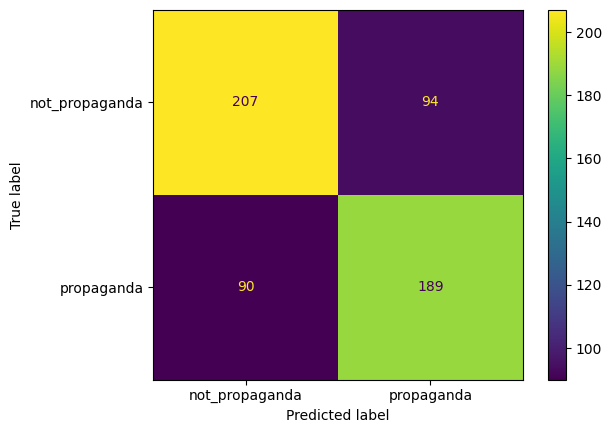

In [ ]:
test_dataset = PropagandaDataset(X_test, y_test, tokenizer, max_length)
test_dataloader = DataLoader(test_dataset, batch_size=result['batch_size'], shuffle=False)
misclassified,correctly_classified = evaluate_model(best_model, test_dataloader)

## Error Analysis

### Sentence length distribution

Test Set - Average Length: 28.91
misclassified - Average Length: 28.86, Maximum Length: 120
Correctly Classified - Average Length: 25.80, Minimum Length: 3


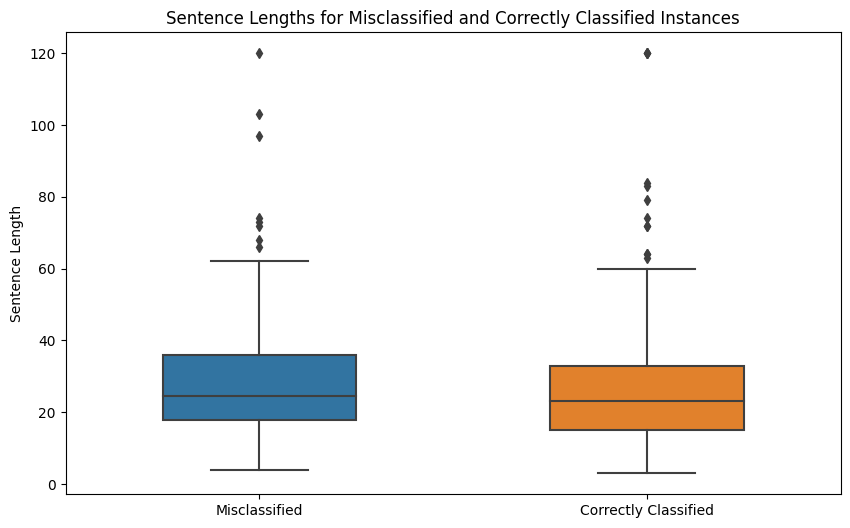

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Get actual lengths of sentences for misclassified and correctly classified instances
misclassified_lengths = [length for _, _, _, length in misclassified]
correctly_classified_lengths = [length for _, _, _, length in correctly_classified]

# Get lengths of all sentences in the test set
all_lengths = [len(sentence.split()) for sentence in X_test]

# Calculate the statistics
testset_avg_len = sum(all_lengths) / len(all_lengths)
misclassified_avg_len = sum(misclassified_lengths) / len(misclassified_lengths)
misclassified_max_len = max(misclassified_lengths)
correct_avg_len = sum(correctly_classified_lengths) / len(correctly_classified_lengths)
correct_min_len = min(correctly_classified_lengths)

print(f"Test Set - Average Length: {testset_avg_len:.2f}")
print(f"misclassified - Average Length: {misclassified_avg_len:.2f}, Maximum Length: {misclassified_max_len}")
print(f"Correctly Classified - Average Length: {correct_avg_len:.2f}, Minimum Length: {correct_min_len}")

# Visualize the data using box plots
data = [misclassified_lengths, correctly_classified_lengths]
labels = ['Misclassified', 'Correctly Classified']

plt.figure(figsize=(10, 6))
sns.boxplot(data=data, width=0.5)
plt.xticks(range(len(labels)), labels)
plt.ylabel('Sentence Length')
plt.title('Sentence Lengths for Misclassified and Correctly Classified Instances')
plt.show()


### Most frequent word

In [ ]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
from collections import defaultdict
import re
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def get_top_n_words_with_sentence_count(texts, n=10):
    word_freq = defaultdict(int)
    word_sentence_count = defaultdict(int)
    word_pattern = re.compile(r"^[a-z]+$")

    for text in texts:
        text_words = set()
        for word in text.split():
            if word.lower() not in stop_words and word_pattern.match(word.lower()):
                word_freq[word.lower()] += 1
                if word.lower() not in text_words:
                    text_words.add(word.lower())
                    word_sentence_count[word.lower()] += 1

    sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
    sorted_word_sentence_count = [(word, word_sentence_count[word]) for word, freq in sorted_word_freq]

    return list(zip(sorted_word_freq[:n], sorted_word_sentence_count[:n]))


# Get the sentences from misclassified and correctly_classified instances
misclassified_sentences = tokenizer.sequences_to_texts([input_id for input_id, _, _, _ in misclassified])
correctly_classified_sentences = tokenizer.sequences_to_texts([input_id for input_id, _, _, _ in correctly_classified])

# Get the top 10 most frequent words and their sentence counts for each category
top_10_misclassified_with_sentence_count = get_top_n_words_with_sentence_count(misclassified_sentences)
top_10_correctly_classified_with_sentence_count = get_top_n_words_with_sentence_count(correctly_classified_sentences)

print("Top 10 words in misclassified sentences with their sentence counts:")
for ((word, count), (_, sentence_count)) in top_10_misclassified_with_sentence_count:
    print(f"{word}: {count} (in {sentence_count} sentences)")

print("\nTop 10 words in correctly classified sentences with their sentence counts:")
for ((word, count), (_, sentence_count)) in top_10_correctly_classified_with_sentence_count:
    print(f"{word}: {count} (in {sentence_count} sentences)")

Top 10 words in misclassified sentences with their sentence counts:
bos: 187 (in 184 sentences)
eos: 187 (in 184 sentences)
said: 18 (in 16 sentences)
one: 11 (in 10 sentences)
world: 10 (in 10 sentences)
right: 10 (in 9 sentences)
american: 10 (in 7 sentences)
us: 9 (in 9 sentences)
public: 9 (in 8 sentences)
trump: 9 (in 9 sentences)

Top 10 words in correctly classified sentences with their sentence counts:
bos: 406 (in 396 sentences)
eos: 404 (in 396 sentences)
one: 28 (in 25 sentences)
trump: 26 (in 25 sentences)
would: 26 (in 23 sentences)
said: 24 (in 24 sentences)
people: 22 (in 22 sentences)
u: 18 (in 18 sentences)
may: 16 (in 16 sentences)
also: 16 (in 16 sentences)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Grammartical sturucture analysis

In [ ]:
import spacy
from collections import Counter

nlp = spacy.load('en_core_web_sm')

def get_grammatical_constructs(sentences):
    constructs = []
    for sentence in sentences:
        parsed_sentence = nlp(sentence)
        for token in parsed_sentence:
            constructs.append(token.dep_)
    return Counter(constructs)

misclassified_grammatical_constructs = get_grammatical_constructs(misclassified_sentences)
correctly_classified_grammatical_constructs = get_grammatical_constructs(correctly_classified_sentences)

def get_top_n_grammatical_constructs(counter, n=10):
    return counter.most_common(n)

top_10_misclassified_grammatical_constructs = get_top_n_grammatical_constructs(misclassified_grammatical_constructs)
top_10_correctly_classified_grammatical_constructs = get_top_n_grammatical_constructs(correctly_classified_grammatical_constructs)

print("Top 10 grammatical constructs in misclassified sentences:")
for construct, count in top_10_misclassified_grammatical_constructs:
    print(f"{construct}: {count}")

print("\nTop 10 grammatical constructs in correctly classified sentences:")
for construct, count in top_10_correctly_classified_grammatical_constructs:
    print(f"{construct}: {count}")


Top 10 grammatical constructs in misclassified sentences:
nmod: 50198
pobj: 638
prep: 587
punct: 573
det: 477
nsubj: 466
compound: 458
dobj: 325
amod: 276
aux: 209

Top 10 grammatical constructs in correctly classified sentences:
nmod: 111436
pobj: 1243
punct: 1136
prep: 1082
det: 944
nsubj: 934
compound: 791
dobj: 668
amod: 507
aux: 441


# Word embedding method (glove)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

In [ ]:
import numpy as np

def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_file_path = "glove.6B.300d.txt"
glove_embeddings = load_glove_embeddings(glove_file_path)

In [ ]:
vocab_size = 10000
# Create an embedding matrix
embedding_matrix = np.zeros((vocab_size, 300))

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

## Baseline

In [ ]:
class PropagandaDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_length):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

        self.sentences_seq = self.tokenizer.texts_to_sequences(self.sentences)
        self.sentences_padded = pad_sequences(self.sentences_seq, maxlen=self.max_length, padding='post', truncating='post')
        self.lengths = [min(len(seq), max_length) for seq in self.sentences_seq]

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences_padded[idx]
        label = self.labels[idx]
        length = self.lengths[idx]

        return {
            'input_ids': torch.tensor(sentence, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long),
            'length': length
        }

In [ ]:
import torch
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size=10000, embedding_dim=300, hidden_dim=300, num_classes=2, num_layers=1, dropout=0.5, embedding_matrix=None):
        super(LSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if embedding_matrix is not None:
            self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
            self.embedding.weight.requires_grad = False

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        lstm_out, _ = self.lstm(embedded)
        pooled_out = self.dropout(lstm_out[:, -1, :])
        linear_out = self.fc(pooled_out)
        final_out = self.softmax(linear_out)

        return final_out

In [ ]:
max_length = 120
vocab_size = 10000
batch_size = 32

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

train_dataset = PropagandaDataset(X_train, y_train, tokenizer, max_length)
val_dataset = PropagandaDataset(X_val, y_val, tokenizer, max_length)
test_dataset = PropagandaDataset(X_test, y_test, tokenizer, max_length)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Initialize the LSTM model's embedding layer with the embedding matrix
model = LSTMClassifier(vocab_size=vocab_size, embedding_dim=300,embedding_matrix=embedding_matrix)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

patience = 3
early_stopping_counter = 0
best_val_f1 = -float('inf')

for epoch in range(100):
    model.train()
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validate the model
    model.eval()
    val_predictions = []
    val_labels = []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids)
            predictions = torch.argmax(outputs, dim=1)

            val_predictions.extend(predictions.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    precision, recall, val_f1, _ = precision_recall_fscore_support(val_labels, val_predictions, average='weighted')
    print(f"Epoch: {epoch+1}, Validation F1: {val_f1}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered.")
        break

# Evaluate the model on the test set
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids)
        predictions = torch.argmax(outputs, dim=1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_predictions)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1_score}")

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1, Validation F1: 0.36595934777752964
Epoch: 2, Validation F1: 0.3107495765805029


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3, Validation F1: 0.36595934777752964
Epoch: 4, Validation F1: 0.3107495765805029
Early stopping triggered.
Accuracy: 0.5224137931034483
Precision: 0.6310704022988506
Recall: 0.5224137931034483
F1-score: 0.36524913585046215


## Hyper-parameter tuning

In [ ]:
import itertools
from sklearn.metrics import f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def grid_search(X_train, y_train, X_val, y_val, max_length):
    best_result = None
    best_f1 = float('-inf')
    patience = 10

    dropouts = [0.1, 0.2, 0.3]
    weight_decays = [0.01, 0.001, 0.0001]
    batch_sizes = [16, 32, 64]
    num_layers = [1, 2, 3]
    learning_rate = [0.01,0.001,0.0001]

    total_combinations = len(dropouts) * len(weight_decays) * len(batch_sizes) * len(num_layers) * len(learning_rate)
    current_combination = 0

    for do, wd, bs, nl,lr in itertools.product(dropouts, weight_decays, batch_sizes, num_layers, learning_rate):
        current_combination += 1
        # Create a model with the current hyperparameters
        model = LSTMClassifier(dropout=do, num_layers=nl).to(device)

        # Create dataloaders
        train_dataset = PropagandaDataset(X_train, y_train, tokenizer, max_length)
        train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
        val_dataset = PropagandaDataset(X_val, y_val, tokenizer, max_length)
        val_dataloader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

        # Train the model
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        loss_fn = torch.nn.CrossEntropyLoss()
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, threshold=1e-3, verbose=False)

        early_stopping_counter = 0
        best_val_f1 = -float('inf')

        for epoch in range(1000):
            model.train()
            for batch in train_dataloader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['label'].to(device)

                optimizer.zero_grad()
                outputs = model(input_ids)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()

            # Evaluate the model
            model.eval()
            val_predictions = []
            val_labels = []

            with torch.no_grad():
                for batch in val_dataloader:
                    input_ids = batch['input_ids'].to(device)
                    labels = batch['label'].to(device)

                    outputs = model(input_ids)
                    predictions = torch.argmax(outputs, dim=1)

                    val_predictions.extend(predictions.cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())

            val_f1 = f1_score(val_labels, val_predictions, average='weighted')

            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

            if val_f1 > best_f1:
                best_f1 = val_f1
                best_result = {
                    'dropout': do,
                    'weight_decay': wd,
                    'num_layers': nl,
                    'learning_rate' : lr,
                    'batch_size': bs,
                    'f1': best_f1
                }
            if early_stopping_counter >= patience:
                progress = current_combination / total_combinations
                print(f"Progress: {progress:.2%} | {current_combination}/{total_combinations} | Current Best Result: {best_result}")
                break

            scheduler.step(val_f1)

    return best_result

result = grid_search(X_train, y_train, X_val, y_val, max_length)

print("Best result:", result)

Progress: 0.41% | 1/243 | Current Best Result: {'dropout': 0.1, 'weight_decay': 0.01, 'num_layers': 1, 'learning_rate': 0.01, 'batch_size': 16, 'f1': 0.36595934777752964}
Progress: 0.82% | 2/243 | Current Best Result: {'dropout': 0.1, 'weight_decay': 0.01, 'num_layers': 1, 'learning_rate': 0.01, 'batch_size': 16, 'f1': 0.36595934777752964}
Progress: 1.23% | 3/243 | Current Best Result: {'dropout': 0.1, 'weight_decay': 0.01, 'num_layers': 1, 'learning_rate': 0.01, 'batch_size': 16, 'f1': 0.36595934777752964}
Progress: 1.65% | 4/243 | Current Best Result: {'dropout': 0.1, 'weight_decay': 0.01, 'num_layers': 1, 'learning_rate': 0.01, 'batch_size': 16, 'f1': 0.36595934777752964}
Progress: 2.06% | 5/243 | Current Best Result: {'dropout': 0.1, 'weight_decay': 0.01, 'num_layers': 1, 'learning_rate': 0.01, 'batch_size': 16, 'f1': 0.36595934777752964}
Progress: 2.47% | 6/243 | Current Best Result: {'dropout': 0.1, 'weight_decay': 0.01, 'num_layers': 1, 'learning_rate': 0.01, 'batch_size': 16, '

true
{'dropout': 0.1, 'weight_decay': 0.0001, 'num_layers': 1, 'learning_rate': 0.01, 'batch_size': 32, 'f1': 0.7934733095481284}

false
{'dropout': 0.2, 'weight_decay': 0.0001, 'num_layers': 1, 'learning_rate': 0.01, 'batch_size': 64}

## Evaluate

In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train(X_train, y_train, X_val, y_val, max_length, best_params, vocab_size, embedding_matrix):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = LSTMClassifier(dropout=best_params['dropout'], 
                           num_layers=best_params['num_layers'], 
                           vocab_size=vocab_size, 
                           embedding_matrix=embedding_matrix).to(device)
    train_dataset = PropagandaDataset(X_train, y_train, tokenizer, max_length)
    train_dataloader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)

    val_dataset = PropagandaDataset(X_val, y_val, tokenizer, max_length)
    val_dataloader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
    loss_fn = torch.nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, threshold=1e-3, verbose=False)

    patience = 10
    early_stopping_counter = 0
    best_val_f1 = -float('inf')

    for epoch in range(1000):
        model.train()
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids)
                predictions = torch.argmax(outputs, dim=1)

                val_predictions.extend(predictions.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_f1 = f1_score(val_labels, val_predictions, average='weighted')

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            break

        scheduler.step(val_f1)

    return model


def evaluate_model(model, test_dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_predictions = []
    all_labels = []
    all_input_ids = []
    all_lengths = []

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            lengths = batch['length']

            outputs = model(input_ids)
            predictions = torch.argmax(outputs, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_input_ids.extend(input_ids.cpu().numpy())
            all_lengths.extend(lengths)

    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
    auc_roc = roc_auc_score(all_labels, all_predictions)

    conf_matrix = confusion_matrix(all_labels, all_predictions)

    cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["not_propaganda", "propaganda"])

    class_report = classification_report(all_labels, all_predictions, target_names=["not_propaganda", "propaganda"])

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1_score:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")

    # Visualize confusion matrix
    cm_display.plot()

    # Visualize classification report
    print(class_report)

    misclassified = [(all_input_ids[i], all_labels[i], all_predictions[i], all_lengths[i]) for i in range(len(all_labels)) if all_labels[i] != all_predictions[i]]
    correctly_classified = [(all_input_ids[i], all_labels[i], all_predictions[i], all_lengths[i]) for i in range(len(all_labels)) if all_labels[i] == all_predictions[i]]

    return misclassified, correctly_classified

    


In [ ]:
result = {'dropout': 0.2, 'weight_decay': 0.0001, 'num_layers': 1, 'learning_rate': 0.01, 'batch_size': 64}
best_model = train(X_train, y_train, X_val, y_val, max_length, result, vocab_size, embedding_matrix)

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

Accuracy: 0.4810
Precision: 0.2314
Recall: 0.4810
F1-score: 0.3125
AUC-ROC: 0.5000
                precision    recall  f1-score   support

not_propaganda       0.00      0.00      0.00       301
    propaganda       0.48      1.00      0.65       279

      accuracy                           0.48       580
     macro avg       0.24      0.50      0.32       580
  weighted avg       0.23      0.48      0.31       580



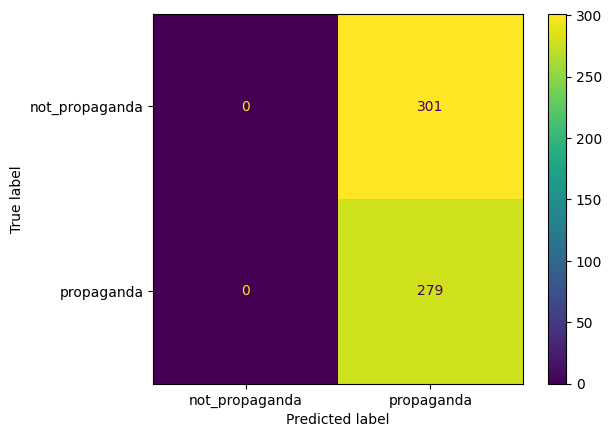

In [ ]:
test_dataset = PropagandaDataset(X_test, y_test, tokenizer, max_length)
test_dataloader = DataLoader(test_dataset, batch_size=result['batch_size'], shuffle=False)
misclassified,correctly_classified = evaluate_model(best_model, test_dataloader)

## Error Analysis

### Sentence length distribution

Test Set - Average Length: 28.91
misclassified - Average Length: 22.92, Maximum Length: 120
Correctly Classified - Average Length: 30.92, Minimum Length: 3


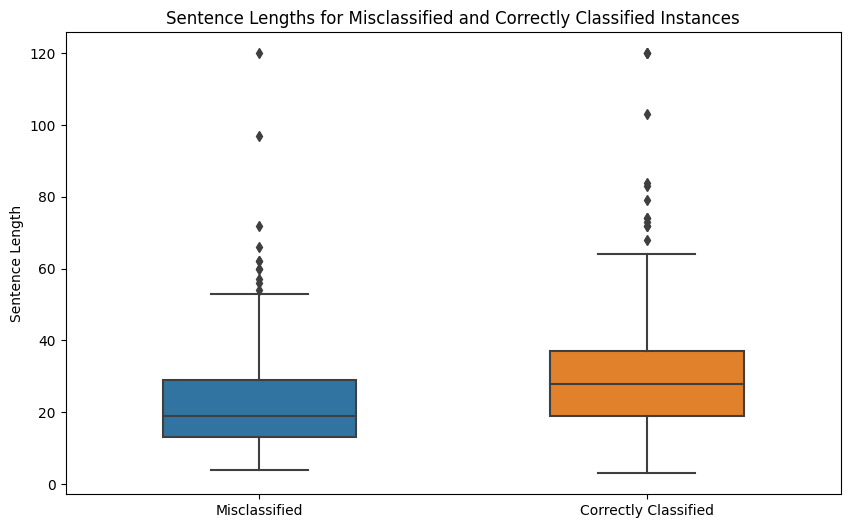

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Get actual lengths of sentences for misclassified and correctly classified instances
misclassified_lengths = [length for _, _, _, length in misclassified]
correctly_classified_lengths = [length for _, _, _, length in correctly_classified]

# Get lengths of all sentences in the test set
all_lengths = [len(sentence.split()) for sentence in X_test]

# Calculate the statistics
testset_avg_len = sum(all_lengths) / len(all_lengths)
misclassified_avg_len = sum(misclassified_lengths) / len(misclassified_lengths)
misclassified_max_len = max(misclassified_lengths)
correct_avg_len = sum(correctly_classified_lengths) / len(correctly_classified_lengths)
correct_min_len = min(correctly_classified_lengths)

print(f"Test Set - Average Length: {testset_avg_len:.2f}")
print(f"misclassified - Average Length: {misclassified_avg_len:.2f}, Maximum Length: {misclassified_max_len}")
print(f"Correctly Classified - Average Length: {correct_avg_len:.2f}, Minimum Length: {correct_min_len}")

# Visualize the data using box plots
data = [misclassified_lengths, correctly_classified_lengths]
labels = ['Misclassified', 'Correctly Classified']

plt.figure(figsize=(10, 6))
sns.boxplot(data=data, width=0.5)
plt.xticks(range(len(labels)), labels)
plt.ylabel('Sentence Length')
plt.title('Sentence Lengths for Misclassified and Correctly Classified Instances')
plt.show()


### Most frequent word

In [ ]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
from collections import defaultdict
import re
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def get_top_n_words_with_sentence_count(texts, n=10):
    word_freq = defaultdict(int)
    word_sentence_count = defaultdict(int)
    word_pattern = re.compile(r"^[a-z]+$")

    for text in texts:
        text_words = set()
        for word in text.split():
            if word.lower() not in stop_words and word_pattern.match(word.lower()):
                word_freq[word.lower()] += 1
                if word.lower() not in text_words:
                    text_words.add(word.lower())
                    word_sentence_count[word.lower()] += 1

    sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
    sorted_word_sentence_count = [(word, word_sentence_count[word]) for word, freq in sorted_word_freq]

    return list(zip(sorted_word_freq[:n], sorted_word_sentence_count[:n]))


# Get the sentences from misclassified and correctly_classified instances
misclassified_sentences = tokenizer.sequences_to_texts([input_id for input_id, _, _, _ in misclassified])
correctly_classified_sentences = tokenizer.sequences_to_texts([input_id for input_id, _, _, _ in correctly_classified])

# Get the top 10 most frequent words and their sentence counts for each category
top_10_misclassified_with_sentence_count = get_top_n_words_with_sentence_count(misclassified_sentences)
top_10_correctly_classified_with_sentence_count = get_top_n_words_with_sentence_count(correctly_classified_sentences)

print("Top 10 words in misclassified sentences with their sentence counts:")
for ((word, count), (_, sentence_count)) in top_10_misclassified_with_sentence_count:
    print(f"{word}: {count} (in {sentence_count} sentences)")

print("\nTop 10 words in correctly classified sentences with their sentence counts:")
for ((word, count), (_, sentence_count)) in top_10_correctly_classified_with_sentence_count:
    print(f"{word}: {count} (in {sentence_count} sentences)")

[nltk_data] Downloading package stopwords to /root/nltk_data...


Top 10 words in misclassified sentences with their sentence counts:
bos: 304 (in 301 sentences)
eos: 304 (in 301 sentences)
said: 24 (in 22 sentences)
one: 19 (in 16 sentences)
may: 13 (in 13 sentences)
u: 13 (in 13 sentences)
also: 12 (in 11 sentences)
never: 12 (in 11 sentences)
people: 11 (in 11 sentences)
right: 11 (in 10 sentences)

Top 10 words in correctly classified sentences with their sentence counts:
bos: 289 (in 279 sentences)
eos: 287 (in 279 sentences)
trump: 30 (in 29 sentences)
would: 22 (in 21 sentences)
one: 20 (in 19 sentences)
world: 19 (in 18 sentences)
said: 18 (in 18 sentences)
people: 16 (in 16 sentences)
public: 16 (in 16 sentences)
american: 16 (in 13 sentences)


[nltk_data]   Unzipping corpora/stopwords.zip.


### Grammartical sturucture analysis

In [ ]:
import spacy
from collections import Counter

nlp = spacy.load('en_core_web_sm')

def get_grammatical_constructs(sentences):
    constructs = []
    for sentence in sentences:
        parsed_sentence = nlp(sentence)
        for token in parsed_sentence:
            constructs.append(token.dep_)
    return Counter(constructs)

misclassified_grammatical_constructs = get_grammatical_constructs(misclassified_sentences)
correctly_classified_grammatical_constructs = get_grammatical_constructs(correctly_classified_sentences)

def get_top_n_grammatical_constructs(counter, n=10):
    return counter.most_common(n)

top_10_misclassified_grammatical_constructs = get_top_n_grammatical_constructs(misclassified_grammatical_constructs)
top_10_correctly_classified_grammatical_constructs = get_top_n_grammatical_constructs(correctly_classified_grammatical_constructs)

print("Top 10 grammatical constructs in misclassified sentences:")
for construct, count in top_10_misclassified_grammatical_constructs:
    print(f"{construct}: {count}")

print("\nTop 10 grammatical constructs in correctly classified sentences:")
for construct, count in top_10_correctly_classified_grammatical_constructs:
    print(f"{construct}: {count}")


Top 10 grammatical constructs in misclassified sentences:
nmod: 87313
pobj: 875
punct: 843
prep: 779
nsubj: 633
compound: 628
det: 611
dobj: 451
ROOT: 323
amod: 319

Top 10 grammatical constructs in correctly classified sentences:
nmod: 74321
pobj: 1006
prep: 890
punct: 866
det: 810
nsubj: 767
compound: 621
dobj: 542
amod: 464
aux: 394
